In [1]:
import sys
import os

project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.insert(0, src_path)


In [2]:
import numpy as np

# === Shifts ===
def shift_right(mat, steps=1):
    return np.roll(mat, shift=steps, axis=1)

def shift_left(mat, steps=1):
    return np.roll(mat, shift=-steps, axis=1)

def shift_down(mat, steps=1):
    return np.roll(mat, shift=steps, axis=0)

def shift_up(mat, steps=1):
    return np.roll(mat, shift=-steps, axis=0)

def shift_diag_down_right(mat, steps=1):
    return np.roll(np.roll(mat, shift=steps, axis=0), shift=steps, axis=1)

def shift_diag_down_left(mat, steps=1):
    return np.roll(np.roll(mat, shift=steps, axis=0), shift=-steps, axis=1)

def shift_diag_up_right(mat, steps=1):
    return np.roll(np.roll(mat, shift=-steps, axis=0), shift=steps, axis=1)

def shift_diag_up_left(mat, steps=1):
    return np.roll(np.roll(mat, shift=-steps, axis=0), shift=-steps, axis=1)

# === New: Rotations (in 90-degree steps) ===
def rotate_clockwise(mat, k=1):
    """Rotate 90 degrees clockwise k times (k=1 means 90°, k=2 means 180°, etc.)"""
    return np.rot90(mat, -k)

def rotate_counterclockwise(mat, k=1):
    """Rotate 90 degrees counterclockwise k times (k=1 means 90°, k=2 means 180°, etc.)"""
    return np.rot90(mat, k)

# === New: Bit Inversion ===
def invert_bits(mat):
    """Assumes binary matrix of 0s and 1s"""
    return 1 - mat


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix_pair(x, y, ctm_val, m_val, index, match_count, best_rule=None, best_depth=None):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2.5))
    cmap = plt.cm.binary

    for ax, mat, title in zip(axes, [x, y], ['Input $X$', 'Target $Y$']):
        ax.imshow(mat, cmap=cmap, vmin=0, vmax=1)
        ax.set_xticks(np.arange(-.5, mat.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, mat.shape[0], 1), minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=1)
        ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.set_title(title)

    # Suptitle with match info
    if best_rule is not None:
        extra = f"Depth: {best_depth}"
    else:
        extra = "No matching rule"

    plt.suptitle(
        f"Pair {index+1} — Matches: {match_count}\n"
        f"$CTM(Y|X) = {ctm_val:.4f}$, $m(Y|X) = {m_val:.4f}$\n{extra}",
        fontsize=10
    )

    plt.tight_layout()
    plt.show()



In [4]:
def canonical_rule_key(rule_int):
    return int(rule_int)  # Ensure consistency

def count_common_rules(results):
    if not results:
        print("No results to process.")
        return 0

    # Build sets of rule IDs per task
    match_rule_sets = [
        set(canonical_rule_key(rule) for rule, _ in res[2])
        for res in results if res[2]
    ]

    if not match_rule_sets:
        print("No matching rules found.")
        return 0

    common_rules = set.intersection(*match_rule_sets)
    count = len(common_rules)
    print(f"Number of common rules across all tasks: {count}")

    if count == 0:
        return 0

    # Find total depth per rule
    depth_totals = {}
    for rule_id in common_rules:
        total_depth = 0
        for (_, _, matches) in results:
            match_dict = {canonical_rule_key(r): d for r, d in matches}
            total_depth += match_dict[rule_id]
        depth_totals[rule_id] = total_depth

    # Find the rule with the lowest total depth
    best_rule = min(depth_totals.items(), key=lambda item: item[1])
    print(f"Best rule (minimum total depth): {best_rule[0]} with total depth {best_rule[1]}")

    return count




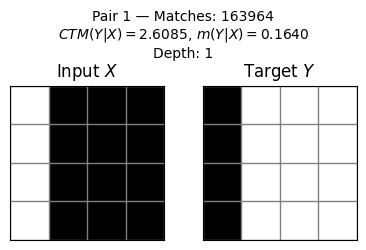

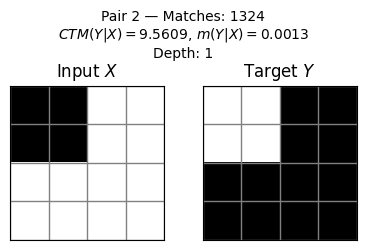

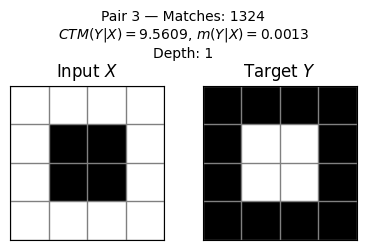

In [5]:
# === Input Matrices ===

x1 = np.array([
    [0, 1, 1, 1],
    [0, 1, 1, 1],
    [0, 1, 1, 1],
    [0, 1, 1, 1]
], dtype=np.uint32)

# y1 = np.array([
#     [1, 0, 1, 1],
#     [0, 1, 0, 0],
#     [1, 0, 1, 1],
#     [1, 1, 0, 1]
# ], dtype=np.uint32)

x2 = np.array([
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=np.uint32)

# y2 = np.array([
#     [0, 1, 1, 0],
#     [0, 1, 1, 0],
#     [0, 1, 1, 0],
#     [0, 1, 1, 0]
# ], dtype=np.uint32)

x3 = np.array([
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0]
], dtype=np.uint32)

# y3 = np.array([
#     [1, 1, 1, 1],
#     [1, 0, 1, 0],
#     [1, 1, 1, 0],
#     [0, 0, 0, 1]
# ], dtype=np.uint32)

# Use rotated versions as target outputs
y1 = invert_bits(x1)
y2 = invert_bits(x2)
y3 = invert_bits(x3)

# Stack into batches
xs = np.stack([x1, x2, x3])
ys = np.stack([y1, y2, y3])

# === Run Conditional CA-CTM ===

from conditional_ctm import CAConditionalCTM

ctm = CAConditionalCTM(num_rules=1_000_000, seed=42, boundary_mode=1)
results = ctm.compute(xs, ys)
# === Plot results ===

for i, (x, y, result) in enumerate(zip(xs, ys, results)):
    k = result["ctm"]
    m = result["m"]
    matches = result["matches"]

    if matches:
        best_rule, best_depth = min(matches, key=lambda t: t[1])
    else:
        best_rule = best_depth = None

    plot_matrix_pair(x, y, k, m, i, match_count=len(matches), best_rule=best_rule, best_depth=best_depth)
